# Evaluation of the Top classifier

This is the evaluation script of the top classifier in the hierarchy of three classifiers. The top classifier outputs a vector of size 2.

The two indices of the vector are the scores that the classifier has calculated based on one 5-second audio clip.

The first indice (0th) is the score/probability that the audio clip is of the Happy/Angry class.

The second indice (1st) is the score/probability that the audio clip is of the Neutral/Sad class.

### library and package importation

In [1]:
import random
import os
import shutil
import glob
import gc
import sys
import h5py
import time
import datetime
import pickle
import librosa
import warnings
import matplotlib.pyplot as plt

from graphs import draw
import graphs

import numpy as np
from numpy import array
import pandas as pd
from pandas.plotting import parallel_coordinates
from pydub import AudioSegment

#imported for testing
import wave
import contextlib

# for outputing file
from scipy.cluster.vq import vq, kmeans, whiten
import scipy.stats.stats as st

from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize
from sklearn.metrics import auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight

import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.constraints import maxnorm
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Add, Dropout, Input, Activation
from keras.layers import TimeDistributed, Bidirectional, LSTM, LeakyReLU
from keras.models import Sequential
from keras.models import load_model
from keras import optimizers, regularizers
from keras.utils import np_utils, to_categorical

from IPython.display import clear_output

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
# print(len(backend.tensorflow_backend._get_available_gpus()) > 0)

sample_rate=44100
hop_length = 441  # frame size= 2*hop
segment_length=int(sample_rate*0.2)  #0.2
segment_pad=int(sample_rate*0.02)     #0.02
overlappiong=int(sample_rate*0.1)   #0.1

NumofFeaturetoUse = 272 # this will re-assigned for different classifiers
frame_number = 48

sys.path.insert(1, '..//components//')
import load_feat_directories

# input new indices file here
# indices_filename = 'D://indices_filename.npy'
# indices=np.load(indices_filename)

Using TensorFlow backend.
C:\Users\yg9ca\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yg9ca\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yg9ca\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yg9ca\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
def avail_modules(directory, prefix):
    module_names = []
    for item in os.listdir(directory):
        if prefix in item:
            module_names.append(directory + item)
            i = module_names.index(directory + item)
            print(str(i) + 'th module')
            print(directory + item)
    return module_names

In [3]:
def comprise_vector(path, dist, reverb, noise):
    vec_to_return = []
    for fname in os.listdir(path):
        components = fname.split('_')
        '''
        if dist == 0 and 'deamp' in components: continue
        if reverb == 0 and 'WetDry' in components: continue
        if noise == 0 and 'noise' in components: continue
        '''
        current_vec = np.load(path + fname)
        vec_to_return.append(current_vec)
        
    vec_to_return = np.array(vec_to_return)
    return vec_to_return

In [4]:
def comprise_label(feature_vector, label):
    label_vec_to_ret = []
    length = len(list(feature_vector))
    for index in range(0, length):
        current_label = [label]
        label_vec_to_ret.append(current_label)
    label_vec_to_ret = np.array(label_vec_to_ret)

    return label_vec_to_ret

def float_compatible(input_np):

    x = np.where(input_np >= np.finfo(np.float32).max)
    for index in range(0, len(x[0])):
        x_position = x[0][index]
        y_position = x[1][index]
        input_np[x_position, y_position] = 0.0
    input_np = np.nan_to_num(input_np)

    return input_np

def update_progress(progress):
    bar_length = 100
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
# allnoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
# homenoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
all_noised_npy = load_feat_directories.allnoised_npy
all_noised_npy_test = load_feat_directories.allnoised_npy_test
home_noised_npy = load_feat_directories.homenoised_npy
home_noised_npy_test = load_feat_directories.homenoised_npy_test

for index in range(0, 5):
    if not os.path.exists(all_noised_npy_test[index]):
        print(all_noised_npy_test[index] + ' does not exist. Breaking the loop... ')
    if not os.path.exists(home_noised_npy[index]):
        print(home_noised_npy_test[index] + 'does not exist. Breaking the loop... ')

//Users//yegao//Documents//Datasets//padded_deamplified_allnoised_reverberated//npy//Happy_npy_test// does not exist. Breaking the loop... 
//Users//yegao//Documents//Datasets//padded_deamplified_homenoised_reverberated//npy//Happy_npy_test//does not exist. Breaking the loop... 
//Users//yegao//Documents//Datasets//padded_deamplified_allnoised_reverberated//npy//Angry_npy_test// does not exist. Breaking the loop... 
//Users//yegao//Documents//Datasets//padded_deamplified_homenoised_reverberated//npy//Angry_npy_test//does not exist. Breaking the loop... 
//Users//yegao//Documents//Datasets//padded_deamplified_allnoised_reverberated//npy//Neutral_npy_test// does not exist. Breaking the loop... 
//Users//yegao//Documents//Datasets//padded_deamplified_homenoised_reverberated//npy//Neutral_npy_test//does not exist. Breaking the loop... 
//Users//yegao//Documents//Datasets//padded_deamplified_allnoised_reverberated//npy//Sad_npy_test// does not exist. Breaking the loop... 
//Users//yegao//Do

In [6]:
emotions = [0, 1, 2, 3]
home_or_all = 'home'
dist = 0
reverb = 0
noise = 0

for index in emotions:
    if home_or_all == 'home':
        path = home_noised_npy_test[index]
    else:
        path = all_noised_npy_test[index]
        
    if index == 0:
        val_h_feat = comprise_vector(path, dist, reverb, noise)
        val_h_label = comprise_label(val_h_feat, index)
    elif index == 1:
        val_a_feat = comprise_vector(path, dist, reverb, noise)
        val_a_label = comprise_label(val_a_feat, index)
    elif index == 2:
        val_n_feat = comprise_vector(path, dist, reverb, noise)
        val_n_label = comprise_label(val_n_feat, index)
    elif index == 3:
        val_s_feat = comprise_vector(path, dist, reverb, noise)
        val_s_label = comprise_label(val_s_feat, index)
    else:
        val_o_feat = comprise_vector(path, dist, reverb, noise)
        val_o_label = comprise_label(val_o_feat, index)     


FileNotFoundError: [WinError 53] The network path was not found: '//Users//yegao//Documents//Datasets//padded_deamplified_homenoised_reverberated//npy//Happy_npy_test//'

# Top (Binary)

In [32]:
def top_eval_all(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            
            one_sample = np.load(emotionFolder + emotionfile)
            one_sample = np.array([one_sample])
            zero_score, one_score = model.predict(one_sample)[0]
            zero_scores.append(zero_score)
            one_scores.append(one_score)

            if val == 0:
                if zero_score > one_score: correct += 1
                else: incorrect += 1
            else:
                if one_score > zero_score: correct += 1
                else: incorrect += 1

            total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [48]:
def top_eval_original(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise 
            
            if original:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                zero_score, one_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score == 1: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > 0: correct += 1
                    else: incorrect += 1
                    
                    
                '''
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                '''
                total += 1
    
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [49]:
def top_eval_deamplified_noised(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_n:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                components = emotionfile.split('_')
                deamplified_amount_position = components.index('deamp') + 1
                deamplified = float(components[deamplified_amount_position])
                deamplified_dbs.append(deamplified)
                
                zero_score, one_score = model.predict(one_sample)[0]
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [50]:
def top_eval_reverbed(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []
    
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if r:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                zero_score, one_score = model.predict(one_sample)[0]
                
                components = emotionfile.split('_')
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [51]:
def top_eval_deamplified_noised_reverbed(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_r_n:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                zero_score, one_score = model.predict(one_sample)[0]
                
                components = emotionfile.split('_')
                
                deamplified_position = components.index('deamp') + 1
                deamplified_dbs.append(float(components[deamplified_position]))
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total))
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors,
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [52]:
def predict_cnn(model):
    y_pred = []
    y_true = []

    for item in list(Label_val):
            if item[0] > item[1]:
                y_true.append(0)
            elif item[0] < item[1]:
                y_true.append(1)
            else:
                y_true.append(0)

    for item in list(model.predict(featureSet_val)):
            if item[0] > item[1]:
                y_pred.append(0)
            elif item[0] < item[1]:
                y_pred.append(1)
            else:
                y_pred.append(0)

    print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
    print('Precision: ' + str(precision_score(y_true, y_pred)))
    print('Recall: ' + str(recall_score(y_true, y_pred)))
    print('f1 score: ' + str(f1_score(y_true, y_pred)))

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print('true positive ' + str(tp))
    print('false positive ' + str(fp))
    print('false negative ' + str(fn))
    print('true negative ' + str(tn))

In [53]:
# Load testing npy files
featureSet_val = float_compatible(np.vstack((val_h_feat, val_a_feat, val_n_feat, val_s_feat)))
Label_val = np.vstack((val_h_label, val_a_label, val_n_label, val_s_label))
Label_val[Label_val == 0] = 0
Label_val[Label_val == 1] = 0
Label_val[Label_val == 2] = 1
Label_val[Label_val == 3] = 1
Label_val = to_categorical(Label_val)
print('evaluation data: ' + str(featureSet_val.shape))
print('evaluation label: ' + str(Label_val.shape))

NameError: name 'val_h_feat' is not defined

In [54]:
directory = '..//..//modules//'
module_prefix = 'Top_'
modules = avail_modules(directory, module_prefix)

0th module
..//..//modules//Checkpoint_home_Top_neurons_home_2048_filters_1024_dropout_0.2_epoch_1000_dense_6.hdf5


In [55]:
title = modules[0]
model = keras.models.load_model(title)

## Specify the directories that contain the files of emotion

In [56]:
emodb_Happy_npy = 'D://Datasets//EMO-DB//wav//npy//Happy//'
emodb_Angry_npy = 'D://Datasets//EMO-DB//wav//npy//Angry//'
emodb_Neutral_npy = 'D://Datasets//EMO-DB//wav//npy//Neutral//'
emodb_Sad_npy = 'D://Datasets//EMO-DB//wav//npy//Sad//'
emodb_Other_npy = 'D://Datasets//EMO-DB//wav//npy//Other//'
emotionFolders = [emodb_Happy_npy, emodb_Angry_npy, emodb_Neutral_npy, emodb_Sad_npy, emodb_Other_npy]

## Only evaluate unmodified wav files

### evaluate the set of Happy validation

In [57]:
dictionary_original_h = top_eval_original([emotionFolders[0]])
one_scores_original_h = dictionary_original_h.get('one_scores')
zero_scores_original_h = dictionary_original_h.get('zero_scores')

correct = 66
incorrect = 5
error rate = 0.07042253521126761
accuracy = 0.9295774647887324
total files = 71


### evaluate the set of Angry validation

In [58]:
dictionary_original_a = top_eval_original([emotionFolders[1]])
one_scores_original_a = dictionary_original_a.get('one_scores')
zero_scores_original_a = dictionary_original_a.get('zero_scores')

correct = 123
incorrect = 4
error rate = 0.031496062992125984
accuracy = 0.968503937007874
total files = 127


### evaluate the set of Neutral validation

In [59]:
dictionary_original_n = top_eval_original([emotionFolders[2]])
one_scores_original_n = dictionary_original_n.get('one_scores')
zero_scores_original_n = dictionary_original_n.get('zero_scores')

correct = 79
incorrect = 0
error rate = 0.0
accuracy = 1.0
total files = 79


### evaluate the set of Sad validation

In [60]:
dictionary_original_s = top_eval_original([emotionFolders[3]])
one_scores_original_s = dictionary_original_s.get('one_scores')
zero_scores_original_s = dictionary_original_s.get('zero_scores')

correct = 62
incorrect = 0
error rate = 0.0
accuracy = 1.0
total files = 62


### draw the plot (evaluation on only unmodified, original wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x187d2904978>)

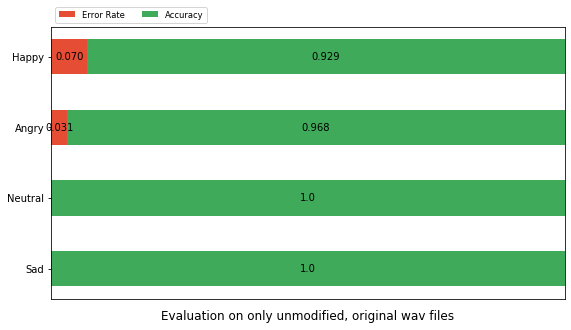

In [61]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only unmodified, original wav files'
results = {
    'Happy': [dictionary_original_h.get('error_rate'), dictionary_original_h.get('accuracy')],
    'Angry': [dictionary_original_a.get('error_rate'), dictionary_original_a.get('accuracy')],
    'Neutral': [dictionary_original_n.get('error_rate'), dictionary_original_n.get('accuracy')],
    'Sad': [dictionary_original_s.get('error_rate'), dictionary_original_s.get('accuracy')]
}

draw(results, category_names, graph_title)

## Only evaluate reverberated wav files

### evaluate the set of Happy validation

In [22]:
dictionary_reverbed_h = top_eval_reverbed([emotionFolders[0]])

one_scores_reverbed_h = dictionary_reverbed_h.get('one_scores')
zero_scores_reverbed_h = dictionary_reverbed_h.get('zero_scores')

wetdrys_reverbed_h = dictionary_reverbed_h.get('wetdrys')
diffusions_reverbed_h = dictionary_reverbed_h.get('diffusions')
decayfactors_reverbed_h = dictionary_reverbed_h.get('decayfactors')

correct = 343
incorrect = 2
error rate = 0.005797101449275362
accuracy = 0.9942028985507246
total files = 345


### evaluate the set of Angry validation

In [23]:
dictionary_reverbed_a = top_eval_reverbed([emotionFolders[1]])

one_scores_reverbed_a = dictionary_reverbed_a.get('one_scores')
zero_scores_reverbed_a = dictionary_reverbed_a.get('zero_scores')

wetdrys_reverbed_a = dictionary_reverbed_a.get('wetdrys')
diffusions_reverbed_a = dictionary_reverbed_a.get('diffusions')
decayfactors_reverbed_a = dictionary_reverbed_a.get('decayfactors')

correct = 315
incorrect = 2
error rate = 0.006309148264984227
accuracy = 0.9936908517350158
total files = 317


### evaluate the set of Neutral validation

In [24]:
dictionary_reverbed_n = top_eval_reverbed([emotionFolders[2]])

one_scores_reverbed_n = dictionary_reverbed_n.get('one_scores')
zero_scores_reverbed_n = dictionary_reverbed_n.get('zero_scores')

wetdrys_reverbed_n = dictionary_reverbed_n.get('wetdrys')
diffusions_reverbed_n = dictionary_reverbed_n.get('diffusions')
decayfactors_reverbed_n = dictionary_reverbed_n.get('decayfactors')

correct = 280
incorrect = 1
error rate = 0.0035587188612099642
accuracy = 0.99644128113879
total files = 281


### evaluate the set of Sad validation

In [25]:
dictionary_reverbed_s = top_eval_reverbed([emotionFolders[2]])

one_scores_reverbed_s = dictionary_reverbed_s.get('one_scores')
zero_scores_reverbed_s = dictionary_reverbed_s.get('zero_scores')

wetdrys_reverbed_s = dictionary_reverbed_s.get('wetdrys')
diffusions_reverbed_s = dictionary_reverbed_s.get('diffusions')
decayfactors_reverbed_s = dictionary_reverbed_s.get('decayfactors')

correct = 280
incorrect = 1
error rate = 0.0035587188612099642
accuracy = 0.99644128113879
total files = 281


### draw the plot (evaluation on only the reverberated wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c283a6a58>)

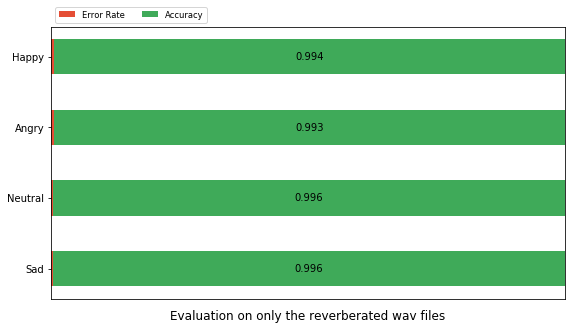

In [26]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only the reverberated wav files'
results = {
    'Happy': [dictionary_reverbed_h.get('error_rate'), dictionary_reverbed_h.get('accuracy')],
    'Angry': [dictionary_reverbed_a.get('error_rate'), dictionary_reverbed_a.get('accuracy')],
    'Neutral': [dictionary_reverbed_n.get('error_rate'), dictionary_reverbed_n.get('accuracy')],
    'Sad': [dictionary_reverbed_s.get('error_rate'), dictionary_reverbed_s.get('accuracy')]
}

draw(results, category_names, graph_title)

/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


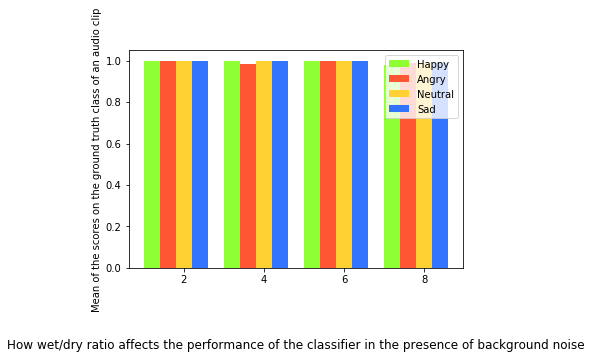

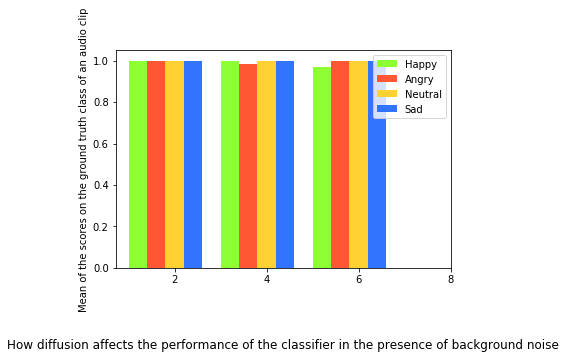

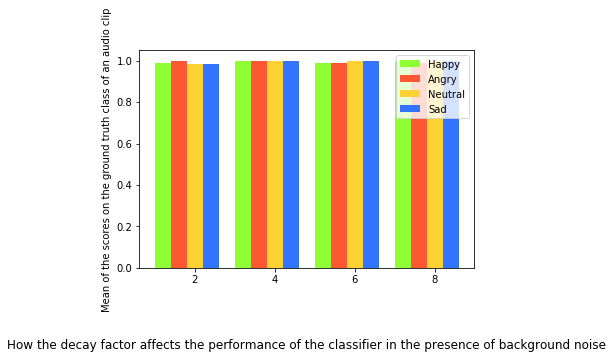

In [27]:
h_WetDry = [wetdrys_reverbed_h, zero_scores_reverbed_h]
a_WetDry = [wetdrys_reverbed_a, zero_scores_reverbed_a]
n_WetDry = [wetdrys_reverbed_n, one_scores_reverbed_n]
s_WetDry = [wetdrys_reverbed_s, one_scores_reverbed_s]

title = 'How wet/dry ratio affects the performance of the classifier in the presence of background noise'
xlabel = 'Wet/dry ratio'
ylabel = 'Mean of the scores on the ground truth class of an audio clip'

graphs.histogram(h_WetDry, a_WetDry, n_WetDry, s_WetDry, title, xlabel, ylabel)

h_Diffusion = [diffusions_reverbed_h, zero_scores_reverbed_h]
a_Diffusion = [diffusions_reverbed_a, zero_scores_reverbed_a]
n_Diffusion = [diffusions_reverbed_n, one_scores_reverbed_n]
s_Diffusion = [diffusions_reverbed_s, one_scores_reverbed_s]

title = 'How diffusion affects the performance of the classifier in the presence of background noise'
xlabel = 'Diffusion value'
ylabel = 'Mean of the scores on the ground truth class of an audio clip'

graphs.histogram(h_Diffusion, a_Diffusion, n_Diffusion, s_Diffusion, title, xlabel, ylabel)

h_DecayFactor = [decayfactors_reverbed_h, zero_scores_reverbed_h]
a_DecayFactor = [decayfactors_reverbed_a, zero_scores_reverbed_a]
n_DecayFactor = [decayfactors_reverbed_n, one_scores_reverbed_n]
s_DecayFactor = [decayfactors_reverbed_s, one_scores_reverbed_s]

title = 'How the decay factor affects the performance of the classifier in the presence of background noise'
xlabel = 'Decay factor value'
ylabel = 'Mean of the scores on the ground truth class of an audio clip'

graphs.histogram(h_DecayFactor, a_DecayFactor, n_DecayFactor, s_DecayFactor, title, xlabel, ylabel)

## Only evaluate deamplified and noised wav files

### evaluate the set of Happy validation

In [28]:
dictionary_deamplified_noised_h = top_eval_deamplified_noised([emotionFolders[0]])

one_scores_deamplified_noised_h = dictionary_deamplified_noised_h.get('one_scores')
zero_scores_deamplified_noised_h = dictionary_deamplified_noised_h.get('zero_scores')
deamplified_dbs_deamplified_noised_h = dictionary_deamplified_noised_h.get('deamplified_dbs')
wetdrys_deamplified_noised_h = dictionary_deamplified_noised_h.get('wetdrys')
diffusions_deamplified_noised_h = dictionary_deamplified_noised_h.get('diffusions')
decayfactors_deamplified_noised_h = dictionary_deamplified_noised_h.get('decayfactors')

correct = 571
incorrect = 24
error rate = 0.040336134453781515
accuracy = 0.9596638655462185
total files = 595


### evaluate the set of Angry validation

In [29]:
dictionary_deamplified_noised_a = top_eval_deamplified_noised([emotionFolders[1]])

one_scores_deamplified_noised_a = dictionary_deamplified_noised_a.get('one_scores')
zero_scores_deamplified_noised_a = dictionary_deamplified_noised_a.get('zero_scores')
deamplified_dbs_deamplified_noised_a = dictionary_deamplified_noised_a.get('deamplified_dbs')
wetdrys_deamplified_noised_a = dictionary_deamplified_noised_a.get('wetdrys')
diffusions_deamplified_noised_a = dictionary_deamplified_noised_a.get('diffusions')
decayfactors_deamplified_noised_a = dictionary_deamplified_noised_a.get('decayfactors')

correct = 624
incorrect = 10
error rate = 0.015772870662460567
accuracy = 0.9842271293375394
total files = 634


### evaluate the set of Neutral validation

In [30]:
dictionary_deamplified_noised_n = top_eval_deamplified_noised([emotionFolders[2]])

one_scores_deamplified_noised_n = dictionary_deamplified_noised_n.get('one_scores')
zero_scores_deamplified_noised_n = dictionary_deamplified_noised_n.get('zero_scores')
deamplified_dbs_deamplified_noised_n = dictionary_deamplified_noised_n.get('deamplified_dbs')
wetdrys_deamplified_noised_n = dictionary_deamplified_noised_n.get('wetdrys')
diffusions_deamplified_noised_n = dictionary_deamplified_noised_n.get('diffusions')
decayfactors_deamplified_noised_n = dictionary_deamplified_noised_n.get('decayfactors')

correct = 572
incorrect = 9
error rate = 0.01549053356282272
accuracy = 0.9845094664371773
total files = 581


### evaluate the set of Sad validation

In [31]:
dictionary_deamplified_noised_s = top_eval_deamplified_noised([emotionFolders[3]])

one_scores_deamplified_noised_s = dictionary_deamplified_noised_s.get('one_scores')
zero_scores_deamplified_noised_s = dictionary_deamplified_noised_s.get('zero_scores')
deamplified_dbs_deamplified_noised_s = dictionary_deamplified_noised_s.get('deamplified_dbs')
wetdrys_deamplified_noised_s = dictionary_deamplified_noised_s.get('wetdrys')
diffusions_deamplified_noised_s = dictionary_deamplified_noised_s.get('diffusions')
decayfactors_deamplified_noised_s = dictionary_deamplified_noised_s.get('decayfactors')

correct = 623
incorrect = 9
error rate = 0.014240506329113924
accuracy = 0.9857594936708861
total files = 632


### draw the plot (evaluation on only the wav files that are deamplified and mixed with noise)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c28c20278>)

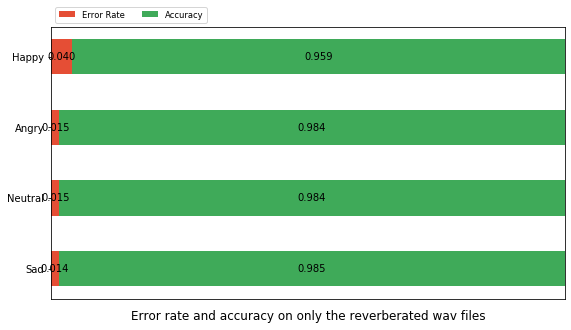

In [32]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Error rate and accuracy on only the reverberated wav files'
results = {
    'Happy': [dictionary_deamplified_noised_h.get('error_rate'), dictionary_deamplified_noised_h.get('accuracy')],
    'Angry': [dictionary_deamplified_noised_a.get('error_rate'), dictionary_deamplified_noised_a.get('accuracy')],
    'Neutral': [dictionary_deamplified_noised_n.get('error_rate'), dictionary_deamplified_noised_n.get('accuracy')],
    'Sad': [dictionary_deamplified_noised_s.get('error_rate'), dictionary_deamplified_noised_s.get('accuracy')]
}

draw(results, category_names, graph_title)

In [33]:
h = [deamplified_dbs_deamplified_noised_h, zero_scores_deamplified_noised_h]
a = [deamplified_dbs_deamplified_noised_a, zero_scores_deamplified_noised_a]
n = [deamplified_dbs_deamplified_noised_n, one_scores_deamplified_noised_n]
s = [deamplified_dbs_deamplified_noised_s, one_scores_deamplified_noised_s]

title = 'How deamplification affects the performance of the classifier in the presence of background noise'
xlabel = 'Deamplified amount measured in decibels'
ylabel = 'Score on the ground truth class of an audio clip'
#graphs.draw_scatter(h, a, n, s, title, xlabel, ylabel)


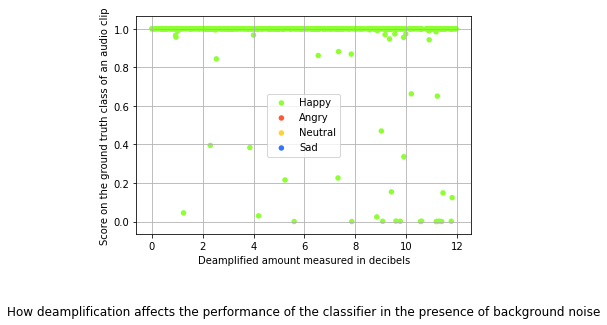

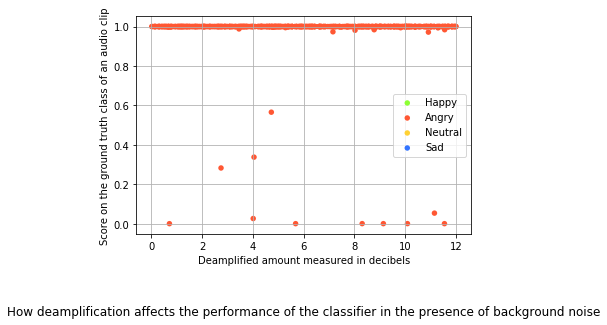

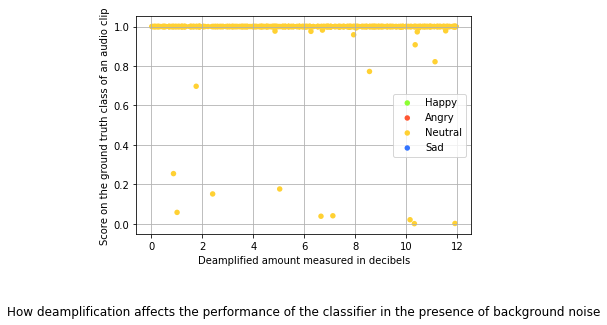

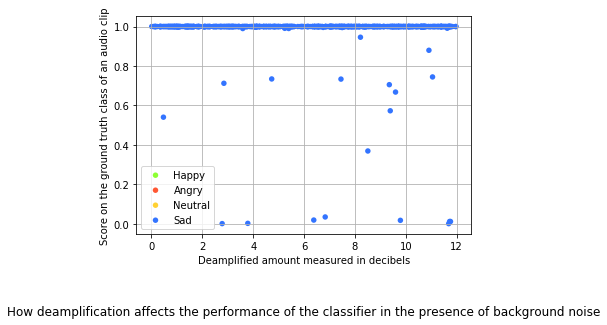

In [34]:
graphs.draw_scatter(h, [[],[]], [[],[]], [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], a, [[],[]], [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], [[],[]], n, [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], [[],[]], [[],[]], s, title, xlabel, ylabel)

## Only evaluate deamplified and noised and reverberated wav files

### evaluate the set of Happy validation

In [35]:
dictionary_deamplified_noised_reverbed_h = top_eval_deamplified_noised_reverbed([emotionFolders[0]])

one_scores_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('one_scores')
zero_scores_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('wetdrys')
diffusions_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('diffusions')
decayfactors_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('decayfactors')

correct = 634
incorrect = 52
error rate = 0.07580174927113703
accuracy = 0.924198250728863
total files = 686
[1.0, 1.0, 1.0, 0.87656164, 1.0, 0.99999964, 0.9999999, 1.0, 1.0, 0.9368057, 1.0, 0.9989151, 1.0, 1.0, 0.99928516, 1.0, 0.9996069, 1.0, 0.980336, 0.9984877, 1.0, 1.0, 1.0, 1.0, 0.99999976, 0.99999404, 1.18786254e-07, 3.7430093e-06, 1.0, 1.0, 1.0, 1.0, 0.9999956, 1.0, 1.0, 0.99996626, 1.0, 0.99756926, 0.99999917, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997495, 0.99993765, 1.0, 0.99999905, 1.0, 1.0, 1.0, 0.99999857, 1.0, 0.99994016, 0.72755903, 0.99998677, 0.20926464, 0.9992244, 1.0, 1.0, 0.00015497794, 1.0, 1.0, 0.82200056, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99997425, 0.27882206, 1.0, 1.0, 0.0058524627, 0.9998022, 0.9942984, 0.9999546, 0.9999993, 0.9995091, 0.99999845, 1.0, 1.0, 1.0, 1.0, 0.99999774, 0.9909533, 0.9999981, 1.0, 1.0, 0.00045611977, 0.99999976, 1.0, 1.0, 1.0, 1.0, 0.9999871, 0.9999597, 0.998492, 1.0, 1.0, 3.521049e-05, 1.0, 1.0, 1.0, 1.0, 0.9999999, 1.0, 1.0, 0.99998975, 0.99

### evaluate the set of Angry validation

In [36]:
dictionary_deamplified_noised_reverbed_a = top_eval_deamplified_noised_reverbed([emotionFolders[1]])

one_scores_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('one_scores')
zero_scores_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('wetdrys')
diffusions_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('diffusions')
decayfactors_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('decayfactors')

correct = 642
incorrect = 23
error rate = 0.03458646616541353
accuracy = 0.9654135338345865
total files = 665
[1.0, 0.4143329, 1.0, 1.0, 0.9999999, 0.9999988, 1.0, 1.0, 1.0, 1.0, 0.99993527, 0.9999999, 1.0, 0.9999838, 0.9999999, 0.9999534, 0.9998994, 1.0, 1.2448756e-06, 1.0, 1.0, 1.0, 0.9999999, 1.0, 1.0, 0.99942684, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.009526731, 1.0, 0.9999994, 0.99995863, 0.29439133, 0.9999999, 0.82774335, 0.9997334, 0.9999999, 1.0, 0.9973923, 1.0, 0.22284421, 0.9999999, 0.99226964, 1.0, 0.9999887, 0.9999994, 0.99760866, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99998534, 0.9996431, 1.0, 0.9999877, 0.99896884, 1.0, 0.9999572, 0.9999682, 1.0, 0.9999989, 1.0, 1.0, 1.0, 0.9997503, 1.0, 1.0, 0.99999917, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999981, 1.0, 1.0, 1.0, 1.0, 0.9855753, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99970967, 1.0, 0.9999999, 1.0, 1.0, 1.0, 0.9999988, 0.037834793, 1.0, 1.0, 0.999987, 1.0, 1.0, 1.0, 0.99946505, 1.0, 0.9993851, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

### evaluate the set of Neutral validation

In [37]:
dictionary_deamplified_noised_reverbed_n = top_eval_deamplified_noised_reverbed([emotionFolders[2]])

one_scores_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('one_scores')
zero_scores_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('wetdrys')
diffusions_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('diffusions')
decayfactors_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('decayfactors')

correct = 519
incorrect = 16
error rate = 0.029906542056074768
accuracy = 0.9700934579439252
total files = 535
[1.3264049e-12, 6.4317293e-24, 1.3748741e-17, 1.836747e-11, 9.9745224e-14, 0.3166459, 1.6524375e-21, 2.975032e-13, 0.95623827, 1.127223e-18, 5.730897e-16, 1.7922706e-14, 6.83405e-29, 1.12516975e-10, 9.390268e-22, 1.9062163e-12, 4.666347e-19, 2.4190038e-08, 5.586281e-23, 1.3073139e-08, 4.043237e-29, 2.4994007e-13, 7.255032e-11, 4.092937e-09, 1.8755685e-34, 1.756448e-11, 3.1647495e-13, 0.9239956, 5.79423e-15, 2.379959e-10, 5.496912e-13, 4.2736133e-06, 0.013873555, 5.3664435e-13, 4.8189808e-09, 0.008466569, 6.7630466e-09, 2.1328959e-05, 0.014490009, 7.893391e-13, 3.2291487e-22, 1.5972558e-14, 6.63174e-14, 9.223848e-11, 2.1062009e-20, 3.0119574e-12, 0.0075585367, 2.1090876e-12, 3.1451771e-15, 1.894936e-11, 2.0000755e-13, 2.9753642e-07, 1.959356e-21, 4.3899016e-12, 2.131248e-12, 2.4780232e-07, 0.00074168295, 0.034037966, 2.992043e-12, 0.00010235137, 5.7787506e-17, 3.8850887e-14, 6.

### evaluate the set of Sad validation

In [38]:
dictionary_deamplified_noised_reverbed_s = top_eval_deamplified_noised_reverbed([emotionFolders[3]])

one_scores_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('one_scores')
zero_scores_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('wetdrys')
diffusions_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('diffusions')
decayfactors_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('decayfactors')

correct = 631
incorrect = 23
error rate = 0.035168195718654434
accuracy = 0.9648318042813455
total files = 654
[0.0014806589, 0.00035692521, 7.9992657e-22, 2.9681436e-22, 7.0205326e-19, 1.5704794e-06, 5.654964e-20, 5.9071514e-10, 8.6761565e-17, 8.077836e-20, 1.5388973e-27, 1.172353e-05, 3.729429e-12, 7.589587e-19, 7.735089e-11, 4.5554694e-07, 0.28395677, 3.9573636e-26, 2.4682052e-24, 3.0323677e-09, 6.2539605e-09, 8.2846003e-07, 1.691551e-08, 5.1128166e-18, 3.8257612e-25, 9.104319e-13, 0.010011973, 2.536965e-09, 6.19158e-12, 5.528744e-08, 8.090313e-08, 2.3328214e-11, 3.710233e-18, 1.2682101e-14, 8.0286145e-07, 6.8115196e-19, 3.4335392e-14, 0.0073524355, 3.3863842e-07, 9.499815e-11, 1.916859e-08, 8.336815e-16, 1.2219061e-24, 5.415438e-17, 1.4227161e-11, 8.6139776e-13, 1.3982157e-16, 4.130052e-21, 1.80753e-05, 8.423072e-21, 9.873357e-09, 3.5936217e-13, 8.086332e-05, 2.1923632e-09, 1.3072915e-08, 8.422997e-16, 3.4631846e-06, 3.2328307e-24, 2.8047062e-09, 4.2324406e-09, 8.220202e-10, 3.0048

### draw the plot (evaluation on only the wav files that are deamplified, mixed with noise, and reverberated)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2baccc18>)

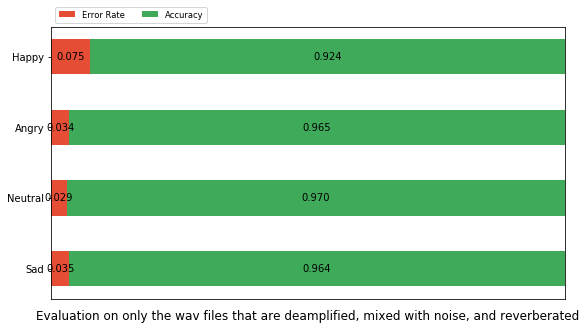

In [39]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only the wav files that are deamplified, mixed with noise, and reverberated'
results = {
    'Happy': [dictionary_deamplified_noised_reverbed_h.get('error_rate'), \
              dictionary_deamplified_noised_reverbed_h.get('accuracy')], \
    'Angry': [dictionary_deamplified_noised_reverbed_a.get('error_rate'), \
              dictionary_deamplified_noised_reverbed_a.get('accuracy')], \
    'Neutral': [dictionary_deamplified_noised_reverbed_n.get('error_rate'), \
                dictionary_deamplified_noised_reverbed_n.get('accuracy')], \
    'Sad': [dictionary_deamplified_noised_reverbed_s.get('error_rate'), \
            dictionary_deamplified_noised_reverbed_s.get('accuracy')]
}

draw(results, category_names, graph_title)

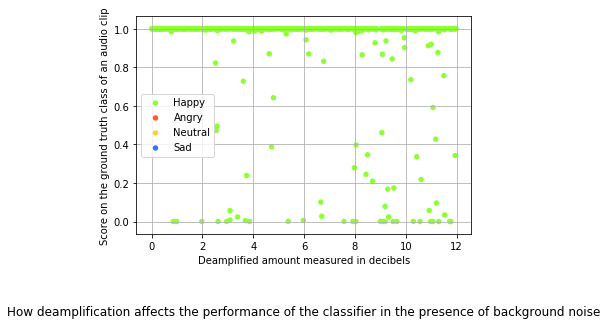

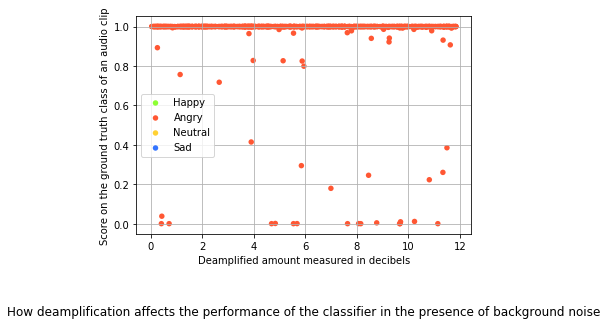

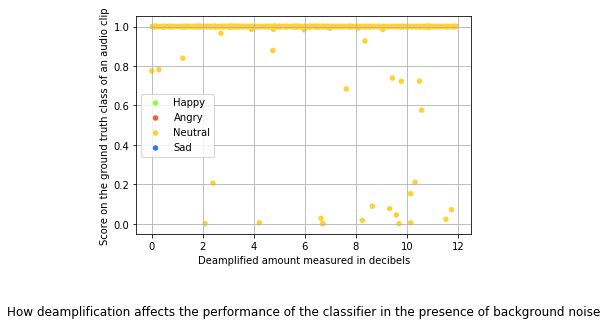

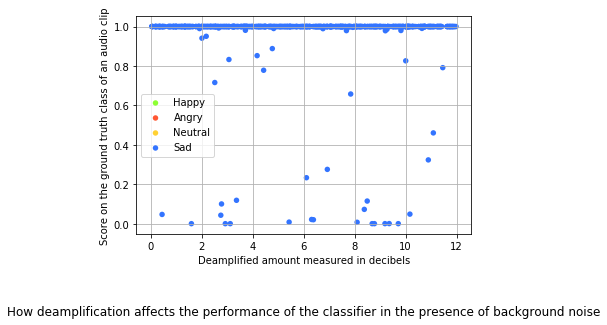

In [40]:
h = [deamplified_dbs_deamplified_noised_reverbed_h, zero_scores_deamplified_noised_reverbed_h]
a = [deamplified_dbs_deamplified_noised_reverbed_a, zero_scores_deamplified_noised_reverbed_a]
n = [deamplified_dbs_deamplified_noised_reverbed_n, one_scores_deamplified_noised_reverbed_n]
s = [deamplified_dbs_deamplified_noised_reverbed_s, one_scores_deamplified_noised_reverbed_s]

title = 'How deamplification affects the performance of the classifier in the presence of background noise'
xlabel = 'Deamplified amount measured in decibels'
ylabel = 'Score on the ground truth class of an audio clip'
#graphs.draw_scatter(h, a, n, s, title, xlabel, ylabel)
graphs.draw_scatter(h, [[],[]], [[],[]], [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], a, [[],[]], [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], [[],[]], n, [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], [[],[]], [[],[]], s, title, xlabel, ylabel)

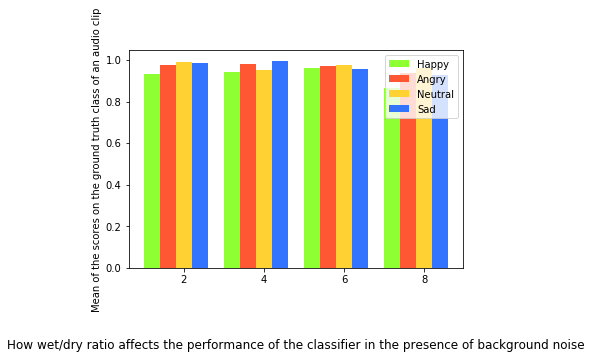

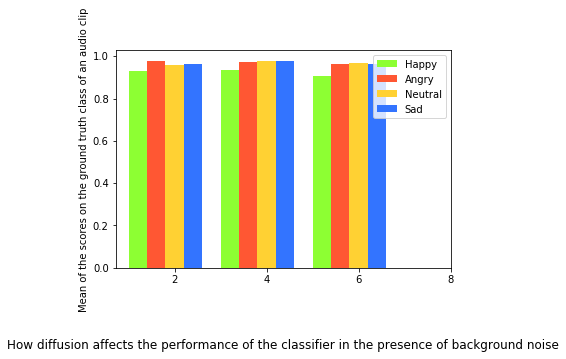

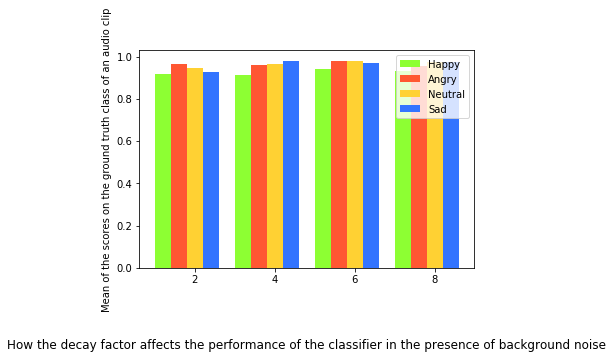

In [41]:
h_WetDry = [wetdrys_deamplified_noised_reverbed_h, zero_scores_deamplified_noised_reverbed_h]
a_WetDry = [wetdrys_deamplified_noised_reverbed_a, zero_scores_deamplified_noised_reverbed_a]
n_WetDry = [wetdrys_deamplified_noised_reverbed_n, one_scores_deamplified_noised_reverbed_n]
s_WetDry = [wetdrys_deamplified_noised_reverbed_s, one_scores_deamplified_noised_reverbed_s]

title = 'How wet/dry ratio affects the performance of the classifier in the presence of background noise'
xlabel = 'Wet/dry ratio'
ylabel = 'Mean of the scores on the ground truth class of an audio clip'
graphs.histogram(h_WetDry, a_WetDry, n_WetDry, s_WetDry, title, xlabel, ylabel)

h_Diffusion = [diffusions_deamplified_noised_reverbed_h, zero_scores_deamplified_noised_reverbed_h]
a_Diffusion = [diffusions_deamplified_noised_reverbed_a, zero_scores_deamplified_noised_reverbed_a]
n_Diffusion = [diffusions_deamplified_noised_reverbed_n, one_scores_deamplified_noised_reverbed_n]
s_Diffusion = [diffusions_deamplified_noised_reverbed_s, one_scores_deamplified_noised_reverbed_s]

title = 'How diffusion affects the performance of the classifier in the presence of background noise'
xlabel = 'Diffusion value'
ylabel = 'Mean of the scores on the ground truth class of an audio clip'

graphs.histogram(h_Diffusion, a_Diffusion, n_Diffusion, s_Diffusion, title, xlabel, ylabel)

h_DecayFactor = [decayfactors_deamplified_noised_reverbed_h, zero_scores_deamplified_noised_reverbed_h]
a_DecayFactor = [decayfactors_deamplified_noised_reverbed_a, zero_scores_deamplified_noised_reverbed_a]
n_DecayFactor = [decayfactors_deamplified_noised_reverbed_n, one_scores_deamplified_noised_reverbed_n]
s_DecayFactor = [decayfactors_deamplified_noised_reverbed_s, one_scores_deamplified_noised_reverbed_s]

title = 'How the decay factor affects the performance of the classifier in the presence of background noise'
xlabel = 'Decay factor value'
ylabel = 'Mean of the scores on the ground truth class of an audio clip'

graphs.histogram(h_DecayFactor, a_DecayFactor, n_DecayFactor, s_DecayFactor, title, xlabel, ylabel)

## Evaluate all wav files

### evaluate the set of Happy validation

In [42]:
dictionary_all_h = top_eval_all([emotionFolders[0]])

one_scores_all_h = dictionary_all_h.get('one_scores')
zero_scores_all_h = dictionary_all_h.get('zero_scores')
deamplified_dbs_all_h = dictionary_all_h.get('deamplified_dbs')
wetdrys_all_h = dictionary_all_h.get('wetdrys')
diffusions_all_h = dictionary_all_h.get('diffusions')
decayfactors_all_h = dictionary_all_h.get('decayfactors')

correct = 1887
incorrect = 79
error rate = 0.04018311291963377
accuracy = 0.9598168870803663
total files = 1966


### evaluate the set of Angry validation

In [43]:
dictionary_all_a = top_eval_all([emotionFolders[1]])

one_scores_all_a = dictionary_all_a.get('one_scores')
zero_scores_all_a = dictionary_all_a.get('zero_scores')
deamplified_dbs_all_a = dictionary_all_a.get('deamplified_dbs')
wetdrys_all_a = dictionary_all_a.get('wetdrys')
diffusions_all_a = dictionary_all_a.get('diffusions')
decayfactors_all_a = dictionary_all_a.get('decayfactors')

correct = 1906
incorrect = 36
error rate = 0.018537590113285273
accuracy = 0.9814624098867147
total files = 1942


### evaluate the set of Neutral validation

In [44]:
dictionary_all_n = top_eval_all([emotionFolders[2]])

one_scores_all_n = dictionary_all_n.get('one_scores')
zero_scores_all_n = dictionary_all_n.get('zero_scores')
deamplified_dbs_all_n = dictionary_all_n.get('deamplified_dbs')
wetdrys_all_n = dictionary_all_n.get('wetdrys')
diffusions_all_n = dictionary_all_n.get('diffusions')
decayfactors_all_n = dictionary_all_n.get('decayfactors')

correct = 1670
incorrect = 26
error rate = 0.015330188679245283
accuracy = 0.9846698113207547
total files = 1696


### evaluate the set of Sad validation

In [45]:
dictionary_all_s = top_eval_all([emotionFolders[3]])

one_scores_all_s = dictionary_all_s.get('one_scores')
zero_scores_all_s = dictionary_all_s.get('zero_scores')
deamplified_dbs_all_s = dictionary_all_s.get('deamplified_dbs')
wetdrys_all_s = dictionary_all_s.get('wetdrys')
diffusions_all_s = dictionary_all_s.get('diffusions')
decayfactors_all_s = dictionary_all_s.get('decayfactors')

correct = 1911
incorrect = 36
error rate = 0.01848998459167951
accuracy = 0.9815100154083205
total files = 1947


### draw the plot (evaluation on all the wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2cc10978>)

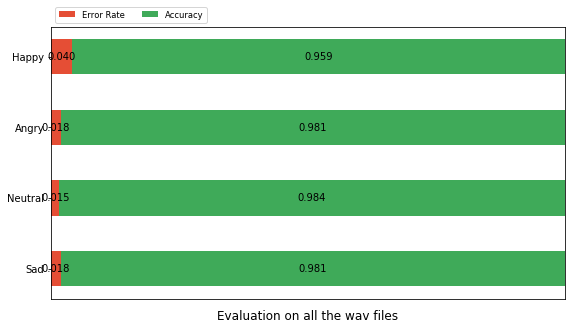

In [46]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on all the wav files'
results = {
    'Happy': [dictionary_all_h.get('error_rate'), dictionary_all_h.get('accuracy')],
    'Angry': [dictionary_all_a.get('error_rate'), dictionary_all_a.get('accuracy')],
    'Neutral': [dictionary_all_n.get('error_rate'), dictionary_all_n.get('accuracy')],
    'Sad': [dictionary_all_s.get('error_rate'), dictionary_all_s.get('accuracy')]
}

draw(results, category_names, graph_title)